In [9]:
import pandas as pd
from numpy.core import multiarray
# from model import *
# from agents import *
# from globals import *
# from server import *
# from schedule import *
# from utility import *
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner, BatchRunnerMP
import pathos
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import time
from tqdm import tqdm
import multiprocessing as mp

In [44]:
datadirk1 = pd.read_csv('dirk1.csv', sep='\t')
datadirk2 = pd.read_pickle('Sensitivity_NType1_Dirk_run2.pkl')
datadirk6 = pd.read_pickle('Sensitivity_NType1_Dirk_runs6.pkl')
datatobias = pd.read_pickle('data1.pkl')
# datamannus = pd.read_pickle('Sensitivity_NType1_mannus_run1.pkl')

In [45]:
datadirk1

,Unnamed: 0,no_of_neighbors,similarity_treshold,social_influence,swingers,beta_component,Run,Echo_Chambers,Silent_Spiral,opinions,radical_opinions,network_type
0,0,2.65918,0.105713,0.523369,3.707031,0.352246,0,9,0.300000,0.550000,0.013333,1
1,1,4.72168,0.105713,0.523369,3.707031,0.352246,1,2,0.233333,0.606667,0.063333,1
2,2,2.65918,0.055439,0.523369,3.707031,0.352246,2,5,0.233333,0.550000,0.036667,1
3,3,2.65918,0.105713,0.900420,3.707031,0.352246,3,9,0.333333,0.526667,0.230000,1
4,4,2.65918,0.105713,0.523369,3.003906,0.352246,4,4,0.266667,0.410000,0.040000,1
5,5,2.65918,0.105713,0.523369,3.707031,0.162402,5,5,0.300000,0.500000,0.046667,1
6,6,2.65918,0.055439,0.900420,3.003906,0.162402,6,8,0.266667,0.400000,0.106667,1
7,7,4.72168,0.105713,0.900420,3.003906,0.162402,7,3,0.166667,0.336667,0.350000,1
8,8,4.72168,0.055439,0.523369,3.003906,0.162402,8,4,0.200000,0.400000,0.146667,1
9,9,4.72168,0.055439,0.900420,3.707031,0.162402,9,13,0.300000,0.216667,0.333333,1


In [26]:
print(datadirk1.head())
print()
print(datadirk2.head())
print()
print(datadirk6.head())
print(datatobias.head())

  Unnamed: 0  no_of_neighbors  similarity_treshold  social_influence  \
0          0          2.65918             0.105713          0.523369   
1          1          4.72168             0.105713          0.523369   
2          2          2.65918             0.055439          0.523369   
3          3          2.65918             0.105713          0.900420   
4          4          2.65918             0.105713          0.523369   

   swingers  beta_component  Run  Echo_Chambers  Silent_Spiral  opinions  \
0  3.707031        0.352246  0.0            9.0       0.300000  0.550000   
1  3.707031        0.352246  1.0            2.0       0.233333  0.606667   
2  3.707031        0.352246  2.0            5.0       0.233333  0.550000   
3  3.707031        0.352246  3.0            9.0       0.333333  0.526667   
4  3.003906        0.352246  4.0            4.0       0.266667  0.410000   

   radical_opinions  network_type  
0          0.013333           1.0  
1          0.063333           1.0  
2 

In [27]:
datacomplete = pd.concat([datadirk2, datatobias])

In [28]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

Parameter S1 S1_conf ST ST_conf
similarity_treshold 0.099628 0.329830 0.840685 0.296830
social_influence -0.055889 0.347069 1.040312 0.376106
swingers 0.042130 0.293646 0.939547 0.409306
Parameter S1 S1_conf ST ST_conf
similarity_treshold 0.868860 0.378090 1.259945 0.382347
social_influence 0.063765 0.392029 0.902423 0.304985
swingers -0.019326 0.303086 0.726444 0.319965


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


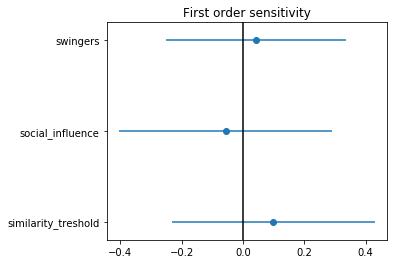

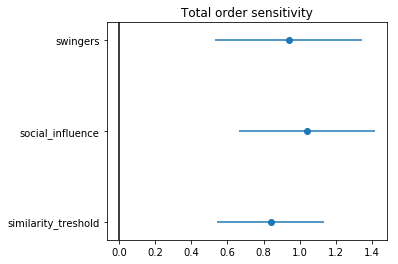

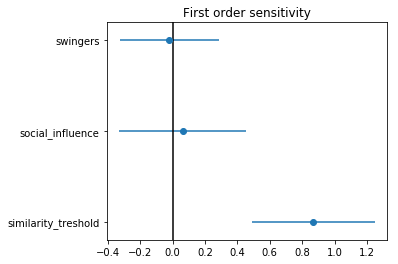

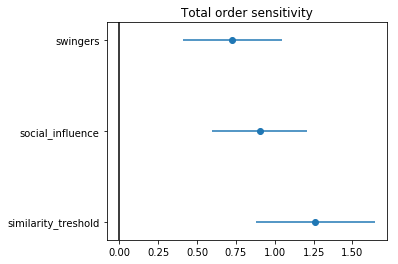

Parameter S1 S1_conf ST ST_conf
similarity_treshold 1.266284 0.913792 1.708792 1.633020
social_influence 0.363127 1.461764 0.969298 0.797428
swingers 0.219117 0.562832 0.298798 0.451287
Parameter S1 S1_conf ST ST_conf
similarity_treshold -0.339732 1.324978 0.556227 0.912675
social_influence -0.404546 1.131123 0.314353 0.881426
swingers 0.510323 0.253994 0.073303 0.028378


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:56: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


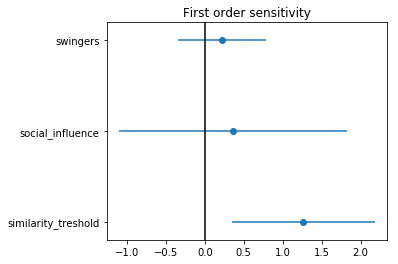

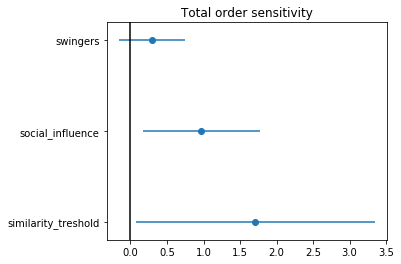

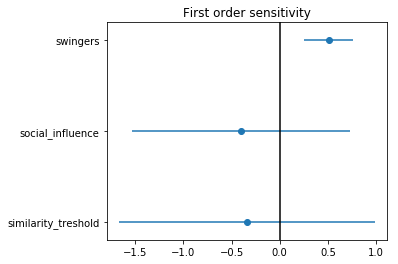

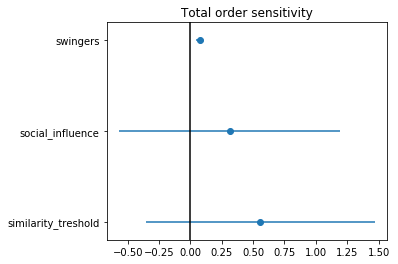

In [58]:


problem = {
    'num_vars': 3,
    'names': ['similarity_treshold', 'social_influence', 'swingers'],
    'bounds': [[0.01,0.05], [0.01, 0.05], [1, 5]]
}

opinions = sobol.analyze(problem, datadirk2['opinions'].as_matrix(), print_to_console=True, calc_second_order=False)
radical_opinions = sobol.analyze(problem, datadirk2['radical_opinions'].as_matrix(), print_to_console=True, calc_second_order=False)



# for Si in (opinions, radical_opinions):
# First order
plot_index(opinions, problem['names'], '1', 'First order sensitivity')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('Ntype1_opinions_first.png')
plt.show()

# Second order
#     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
#     plt.show()

# Total order
plot_index(opinions, problem['names'], 'T', 'Total order sensitivity')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('Ntype1_opinions_total.png')
plt.show()


# for Si in (opinions, radical_opinions):
# First order
plot_index(radical_opinions, problem['names'], '1', 'First order sensitivity')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('Ntype1_radicalopinions_first.png')
plt.show()

# Second order
#     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
#     plt.show()

# Total order
plot_index(radical_opinions, problem['names'], 'T', 'Total order sensitivity')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('Ntype1_radicalopinions_total.png')
plt.show()







opinions = sobol.analyze(problem, datatobias['opinions'].as_matrix(), print_to_console=True, calc_second_order=False)
radical_opinions = sobol.analyze(problem, datatobias['radical_opinions'].as_matrix(), print_to_console=True, calc_second_order=False)



# for Si in (opinions, radical_opinions):
# First order
plot_index(opinions, problem['names'], '1', 'First order sensitivity')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('Ntype2_opinions_first.png')
plt.show()

# Second order
#     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
#     plt.show()

# Total order
plot_index(opinions, problem['names'], 'T', 'Total order sensitivity')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('Ntype2_opinions_total.png')
plt.show()


# for Si in (opinions, radical_opinions):
# First order
plot_index(radical_opinions, problem['names'], '1', 'First order sensitivity')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('Ntype2_radicalopinions_first.png')
plt.show()

# Second order
#     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
#     plt.show()

# Total order
plot_index(radical_opinions, problem['names'], 'T', 'Total order sensitivity')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('Ntype2_radicalopinions_total.png')
plt.show()


Parameter S1 S1_conf ST ST_conf
swingers -0.134319 0.190662 1.002599 0.189665
no_of_neighbors -0.129237 0.214271 0.999315 0.203137
beta_component -0.127414 0.225300 1.076791 0.171000
Parameter S1 S1_conf ST ST_conf
swingers 0.023448 0.156580 0.645164 0.150812
no_of_neighbors 0.170693 0.113719 0.585504 0.149125
beta_component 0.188276 0.184241 0.918243 0.193394


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


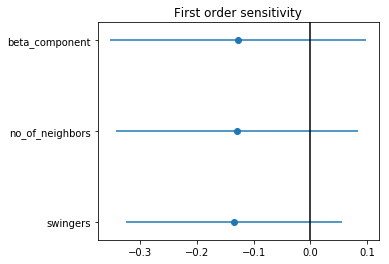

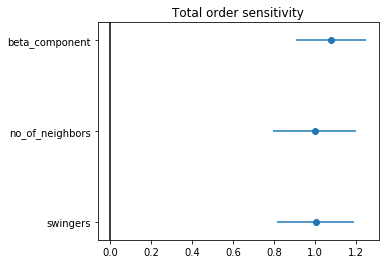

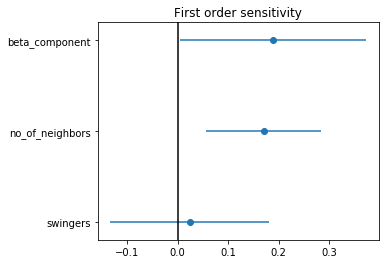

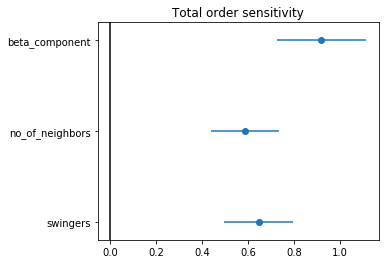

KeyError: 'opinions'

In [59]:


problem = {
    'num_vars': 3,
    'names': [ 'swingers', 'no_of_neighbors', 'beta_component'],
    'bounds': [[0.01,0.05], [0.01, 0.05], [1, 5]]
}

opinions = sobol.analyze(problem, datadirk1['opinions'].as_matrix(), print_to_console=True, calc_second_order=False)
radical_opinions = sobol.analyze(problem, datadirk1['radical_opinions'].as_matrix(), print_to_console=True, calc_second_order=False)



# for Si in (opinions, radical_opinions):
# First order
plot_index(opinions, problem['names'], '1', 'First order sensitivity')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('Ntype1_opinions1_first.png')
plt.show()

# Second order
#     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
#     plt.show()

# Total order
plot_index(opinions, problem['names'], 'T', 'Total order sensitivity')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('Ntype1_opinions1_total.png')
plt.show()


# for Si in (opinions, radical_opinions):
# First order
plot_index(radical_opinions, problem['names'], '1', 'First order sensitivity')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('Ntype1_radicalopinions1_first.png')
plt.show()

# Second order
#     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
#     plt.show()

# Total order
plot_index(radical_opinions, problem['names'], 'T', 'Total order sensitivity')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('Ntype1_radicalopinions1_total.png')
plt.show()







opinions = sobol.analyze(problem, datadirk6['opinions'].as_matrix(), print_to_console=True, calc_second_order=False)
radical_opinions = sobol.analyze(problem, datadirk6['radical_opinions'].as_matrix(), print_to_console=True, calc_second_order=False)



# for Si in (opinions, radical_opinions):
# First order
plot_index(opinions, problem['names'], '1', 'First order sensitivity')
# plt.savefig('Ntype2_opinions.png')
plt.show()

# Second order
#     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
#     plt.show()

# Total order
plot_index(opinions, problem['names'], 'T', 'Total order sensitivity')
# plt.savefig('Ntype2_opinions.png')
plt.show()


# for Si in (opinions, radical_opinions):
# First order
plot_index(radical_opinions, problem['names'], '1', 'First order sensitivity')
# plt.savefig('Ntype2_radicalopinions.png')
plt.show()

# Second order
#     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
#     plt.show()

# Total order
plot_index(radical_opinions, problem['names'], 'T', 'Total order sensitivity')
# plt.savefig('Ntype2_radicalopinions.png')
plt.show()
